In [10]:
import numpy as np

import pandas as pd

import torch

import torch.nn as nn

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report

import transformers

from transformers import AutoModel, BertTokenizerFast

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import BertTokenizerFast

import matplotlib

device = torch.device("cuda")

In [11]:
df= pd.read_csv('bert_test.csv')
df

,Comment_Id,Comment_Text,Racial
0,203468,Ok thanks you for your answer I am a beginner ...,0
1,225898,Standard says about arrow comparisons Otherwis...,0
2,223540,Whoops I m on roving so seeing everything dela...,0
3,244364,FWIW this question ranks highly on Google when...,0
4,233839,Are you able to post a sample of the data to S...,0
...,...,...,...
3465,133936,how come that its a spam you nigga?,1
3466,132338,English? This is english! Learn how to code idiot,1
3467,107627,Questions in English do not start with “But I ...,1
3468,129968,You're not really answering to the essential q...,1


In [12]:
df['Racial'].value_counts(normalize = True)

Racial
0    0.5
1    0.5
Name: proportion, dtype: float64

In [13]:
  #split train dataset into train, validation and test sets

train_text, temp_text, train_labels, temp_labels = train_test_split(df['Comment_Text'], df['Racial'],

                                                                    random_state=2018,

                                                                    test_size=0.3,
                                                                    
                                                                    stratify=df['Racial'])

In [14]:
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,

                                                                random_state=2018,

                                                                test_size=0.5,

                                                                stratify=temp_labels)

<Axes: >

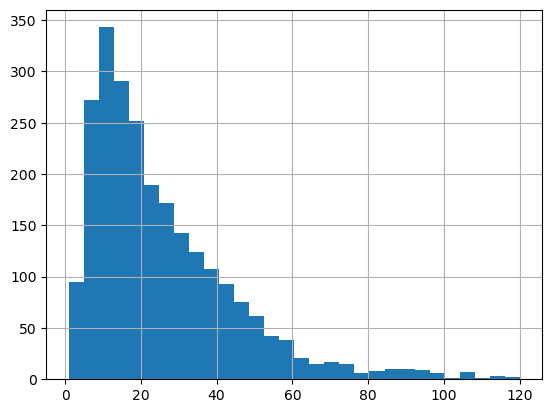

In [15]:

# import BERT-base pretrained model

bert = AutoModel.from_pretrained('bert-base-uncased')



# Load the BERT tokenizer

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')



seq_len = [len(i.split()) for i in train_text]



pd.Series(seq_len).hist(bins = 30)

In [16]:
# tokenize and encode sequences in the training set

tokens_train = tokenizer.batch_encode_plus(

    train_text.tolist(),

    max_length = None,#max_length = 25,

    padding = True,#pad_to_max_length=True,

    truncation=True

)



# tokenize and encode sequences in the validation set

tokens_val = tokenizer.batch_encode_plus(

    val_text.tolist(),

    max_length = None,#max_length = 25,

    padding = True,#pad_to_max_length=True,

    truncation=True

)



# tokenize and encode sequences in the test set

tokens_test = tokenizer.batch_encode_plus(

    test_text.tolist(),

    max_length = None, #max_length = 25,

    padding = True,#pad_to_max_length=True,

    truncation=True

)


In [18]:
train_seq = torch.tensor(tokens_train['input_ids'])

train_mask = torch.tensor(tokens_train['attention_mask'])

train_y = torch.tensor(train_labels.tolist())



val_seq = torch.tensor(tokens_val['input_ids'])

val_mask = torch.tensor(tokens_val['attention_mask'])

val_y = torch.tensor(val_labels.tolist())



test_seq = torch.tensor(tokens_test['input_ids'])

test_mask = torch.tensor(tokens_test['attention_mask'])

test_y = torch.tensor(test_labels.tolist())

In [19]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [20]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [21]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.1)

        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)
              # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

        #pass the inputs to the model
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)

        # apply softmax activation
        x = self.softmax(x)

        return x

In [22]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
# model = model.to(device)

In [23]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5)

c:\Users\64220\miniconda3\Lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [24]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)

print("Class Weights:",class_weights)

Class Weights: [1.00041186 0.99958848]


In [25]:
# converting list of class weights to a tensor

weights= torch.tensor(class_weights,dtype=torch.float)



# push to GPU

#weights = weights.to(device)



# define the loss function

cross_entropy  = nn.NLLLoss(weight=weights)



# number of training epochs

epochs = 10

In [26]:
# function to train the model

def train():



    model.train()

    total_loss, total_accuracy = 0, 0



    # empty list to save model predictions

    total_preds=[]



    # iterate over batches

    for step,batch in enumerate(train_dataloader):

# progress update after every 50 batches.

        if step % 50 == 0 and not step == 0:

            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))



        # push the batch to gpu

        #batch = [r.to(device) for r in batch]

        batch = [r for r in batch]



        sent_id, mask, labels = batch



        # clear previously calculated gradients

        model.zero_grad()



        # get model predictions for the current batch

        preds = model(sent_id, mask)



        # compute the loss between actual and predicted values

        loss = cross_entropy(preds, labels)



        # add on to the total loss

        total_loss = total_loss + loss.item()



        # backward pass to calculate the gradients

        loss.backward()



        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)



        # update parameters

        optimizer.step()



        # model predictions are stored on GPU. So, push it to CPU

        preds=preds.detach().cpu().numpy()



    # append the model predictions

    total_preds.append(preds)



    # compute the training loss of the epoch

    avg_loss = total_loss / len(train_dataloader)



      # predictions are in the form of (no. of batches, size of batch, no. of classes).

      # reshape the predictions in form of (number of samples, no. of classes)

    total_preds  = np.concatenate(total_preds, axis=0)



    #returns the loss and predictions

    return avg_loss, total_preds

In [27]:
def evaluate():



    print("\nEvaluating...")



    # deactivate dropout layers

    model.eval()



    total_loss, total_accuracy = 0, 0



    # empty list to save the model predictions

    total_preds = []



    # iterate over batches

    for step,batch in enumerate(val_dataloader):



        # Progress update every 50 batches.

        if step % 50 == 0 and not step == 0:



            # Calculate elapsed time in minutes.

            elapsed = format_time(time.time() - t0)



            # Report progress.

            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))



        # push the batch to gpu

        #batch = [t.to(device) for t in batch]

        batch = [t for t in batch]



        sent_id, mask, labels = batch



        # deactivate autograd

        with torch.no_grad():



            # model predictions

            preds = model(sent_id, mask)



            # compute the validation loss between actual and predicted values

            loss = cross_entropy(preds,labels)



            total_loss = total_loss + loss.item()



            preds = preds.detach().cpu().numpy()



            total_preds.append(preds)



    # compute the validation loss of the epoch

    avg_loss = total_loss / len(val_dataloader)



    # reshape the predictions in form of (number of samples, no. of classes)

    total_preds  = np.concatenate(total_preds, axis=0)



    return avg_loss, total_preds

In [28]:
# set initial loss to infinite

best_valid_loss = float('inf')



# empty lists to store training and validation loss of each epoch

train_losses=[]

valid_losses=[]



#for each epoch

for epoch in range(epochs):



    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))



    #train model

    train_loss, _ = train()



    #evaluate model

    valid_loss, _ = evaluate()



    #save the best model

    if valid_loss < best_valid_loss:

        best_valid_loss = valid_loss

        torch.save(model.state_dict(), 'saved_weights.pt')



    # append training and validation loss

    train_losses.append(train_loss)

    valid_losses.append(valid_loss)



    print(f'\nTraining Loss: {train_loss:.3f}')

    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of     76.

Evaluating...

Training Loss: 0.656
Validation Loss: 0.617

 Epoch 2 / 10
  Batch    50  of     76.

Evaluating...

Training Loss: 0.609
Validation Loss: 0.570

 Epoch 3 / 10
  Batch    50  of     76.

Evaluating...

Training Loss: 0.569
Validation Loss: 0.553

 Epoch 4 / 10
  Batch    50  of     76.

Evaluating...

Training Loss: 0.555
Validation Loss: 0.528

 Epoch 5 / 10
  Batch    50  of     76.

Evaluating...

Training Loss: 0.542
Validation Loss: 0.506

 Epoch 6 / 10
  Batch    50  of     76.

Evaluating...

Training Loss: 0.518
Validation Loss: 0.492

 Epoch 7 / 10
  Batch    50  of     76.

Evaluating...

Training Loss: 0.508
Validation Loss: 0.480

 Epoch 8 / 10
  Batch    50  of     76.

Evaluating...

Training Loss: 0.490
Validation Loss: 0.459

 Epoch 9 / 10
  Batch    50  of     76.

Evaluating...

Training Loss: 0.478
Validation Loss: 0.440

 Epoch 10 / 10
  Batch    50  of     76.

Evaluating...

Training Loss: 0.453
Validation L

In [31]:
    #load weights of best model

path = 'saved_weights.pt'

model.load_state_dict(torch.load(path))

 

# get predictions for test data

with torch.no_grad():

        preds = model(test_seq, test_mask)

        preds = preds.detach().cpu().numpy()

# model's performanceex

preds = np.argmax(preds, axis = 1)

print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.93      0.73      0.82       261
           1       0.78      0.94      0.85       260

    accuracy                           0.83       521
   macro avg       0.85      0.84      0.83       521
weighted avg       0.85      0.83      0.83       521

